# Network Intrusion Detection

The following example is an extension of `example.ipynb`, based on the paper [A Quantum Feature Selection Method for Network Intrusion Detection](https://ieeexplore.ieee.org/document/9973722). In many machine learning problems, features will be categorized into different *feature classes*. 

This will be performed on the NSL-KDD dataset, which is a cleaned version of the KDDCUP99 dataset. KDDTraint+ and KDDTest+ are the training and testing sets of NSL-KDD respectively.

The 42 features are split into 4 distinct classes:

- Basic network connection features
- Content related features
- Time-related traffic features
- Host-based traffic features

The data itself is classified into 5 types of network attacks: Normal, DoS, Probe, R2L, and U2R, which are encoded with integers 0-4.

In [ ]:
# Copyright (c) 2025, InfinityQ Technology Inc.

import matplotlib.pyplot as plt
import numpy as np
import logging
import pandas as pd
from model_generation import *
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from titanq import Model, Vtype

import warnings

# Filter out FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

logging.getLogger('botocore').setLevel(logging.CRITICAL)
logging.getLogger('urllib3').setLevel(logging.CRITICAL)
logging.getLogger("sklearnex").setLevel(logging.ERROR)

## Setting Credentials
The user should configure their TitanQ API key here.

In [2]:
# Obtain your API key by contacting --> support@infinityq.tech

TITANQ_DEV_API_KEY = None
# Example: TITANQ_DEV_API_KEY = "00000000-0000-0000-0000-000000000000"

## Loading Data and Preprocessing

Here we load in our training and testing dataset and prepare our data for feature selection and training.

The preprocessing steps are as follows:

- Drop rows with NaN values and duplicates
- Map the 5 attack types which are originally strings to integers between 0-4
- Drop constant features that are redundant
- One-hot encode categorical types into binary features

In [3]:
# Ignoring dtype warning from reading in data (gets fixed in preprocessing)
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)

# Load data in
df_train = pd.read_csv("./data/KDDTrain+.txt", header=None)
df_test = pd.read_csv("./data/KDDTest+.txt", header=None)
# removing success_pred from data set. Does not appear in the original NSL-KDD data set used in the paper
df_train = df_train.iloc[:, :-1]
df_test = df_test.iloc[:, :-1]

# Defining feature classes
feature_classes = {
    0: ["basic", (0,9)], # Eg Features 0 - 8 are part of the basic feature class
    1: ["content", (9,22)],
    2: ["time", (22,31)],
    3: ["host", (31,41)]
}

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']
print(f"Number of features before preprocessing: {len(header_names) - 1}\n") # minus label
df_train.columns = header_names
df_test.columns = header_names

# Preprocess data
feature_classes_updated, feat_indices, df_train, df_test = preprocess_data(feature_classes, df_train, df_test)
print(f"Feature classes: {feature_classes_updated}")
print(f"One-hot encoded features: {feat_indices}")

# Separating into X and y datasets
y_train = df_train["label"].to_numpy().astype('int32')
y_test = df_test["label"].to_numpy().astype('int32')

df_train = df_train.drop(columns=["label"])
df_test = df_test.drop(columns=["label"])

X_train = df_train.to_numpy()
X_test = df_test.to_numpy()

num_features = X_train.shape[1]
print(f"\nNumber of features after preprocessing: {num_features}")

Number of features before preprocessing: 41

Dropping duplicates and nan values...
Dropping constant feature(s): {'num_outbound_cmds'}
One-hot encoding: ['protocol_type', 'service', 'flag']
Num features added to protocol_type: 2
Num features added to service: 69
Num features added to flag: 10
Feature classes: {0: ['basic', (0, 90)], 1: ['content', (90, 102)], 2: ['time', (102, 111)], 3: ['host', (111, 121)]}
One-hot encoded features: {'protocol_type': (1, 4), 'service': (4, 74), 'flag': (74, 85)}

Number of features after preprocessing: 121


Here we form the weights matrix (Mutual Information matrix between all features) and set our hyperparameters $\alpha$ and $\beta$. $\alpha$ is the relative weighting of importance and redundancy of features, $\beta$ is a scaling constant for importance, and $K$ is the number of features to select. As per the paper, we use $K$ as our value for $\beta$. Note that the matrix we cache uses a $\beta$ of 1 and we multiply the main diagonal by $K$ to get the desired matrix. In this way, $K$ can be changed freely without having to recompute.

In [4]:
# Defining hyperparameters
alpha = 0.75
K = 13

filename = "weights"

# Constructing matrices
# weights = MI_matrix(X_train, y_train, alpha, 1)
# np.save(f"./weights/{filename}_MI.npy", weights)

# weights = pearson_matrix(X_train, y_train, alpha, 1)
# np.save(f"./weights/{filename}_pears.npy", weights)

# Loading in weights matrix
# weights = np.load(f"./weights/{filename}_MI.npy") # Mutual Information
weights = np.load(f"./weights/{filename}_pears.npy") # Pearson Correlation

# multiply the diagonal by K so we only have to save one matrix
weights[np.diag_indices_from(weights)] *= K

## Input Problem into TitanQ SDK
Now we can input the problem into TitanQ and derive a solution. $x$ is a binary variable determining which features will be selected. $S$ is a variable denoting the number of features to select from each of the 4 feature classes. 

Note that the bounds for elements of S are from 0 to num_features. That is, we can select any number of features from each feature class. The bounds can be adjusted if desired. In the paper this feature class division is done due to lack of qubits. TitanQ has no such restriction but we formalize these constraints regardless to show how it would be done.

The features we one-hot encoded are highly correlated and thus should all be included if one is included. 

In [5]:
print("Creating model...")
#############
# TitanQ Model
#############
model = Model(
    api_key=TITANQ_DEV_API_KEY
)

# Defining variables, objective, and constraints in TitanQ model
x = model.add_variable_vector('x', num_features, Vtype.BINARY)
z = model.add_variable_vector('z', 3, Vtype.BINARY)
# Maximum number of features to select from each feature class. 
S = model.add_variable_vector('S', 4, Vtype.INTEGER, [(0, num_features)] * 4)

weights = np.float32(weights)

print("Adding constraints...")

# Keep highly correlated features together (eg one-hot encoded features)
i = 0
for feat, ind in feat_indices.items():
    start = ind[0]
    end = ind[1]
    for j in range(start, end):
        model.add_constraint_from_expression(x[j] == z[i])

# Limit on number of features selected in each feature class
for i, s in enumerate(S):
    r = feature_classes_updated[i][1]
    model.add_constraint_from_expression(sum(x[r[0]:r[1]]) == s)

# Sum of selected features in each feature class 
model.add_constraint_from_expression(sum(S) == K)

# Objective function
model.set_objective_expression(x.T @ weights @ x)

# TitanQ Solver hyperparameters
num_chains = 32
num_engines = 8
T_min = 0.0001
timeout_in_secs = 40
T_max = 550
penalty_scaling = 10
beta = (1/np.linspace(T_min, T_max, num_chains, dtype=np.float32)).tolist()
print("Solving...")
response = model.optimize(beta=beta, num_chains=num_chains, num_engines=num_engines, timeout_in_secs=timeout_in_secs, penalty_scaling=penalty_scaling)
print("Done solving!")

Creating model...
Adding constraints...
Solving...


Output()

Done solving!


In [6]:
# Getting best solution
objective = response.computation_metrics()["solutions_objective_value"]

best_index = objective.index(min(objective))
solution = response.x[best_index]
print(solution)
print(f"S: {response.S[best_index]}")
print(f"z: {response.z[best_index]}")

# Indices of all the selected features
selected_features = np.where(solution==1)[0]
print(f"Number of features selected: {len(selected_features)}")
print(f"Selected features: {list(df_train.columns[solution == 1])}")

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1.]
S: [2. 1. 5. 5.]
z: [0. 0. 0.]
Number of features selected: 13
Selected features: ['duration', 'dst_bytes', 'hot', 'count', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'diff_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


## Measuring Performance
To test the performance of our solution, we determine the performance Random Forest Classifier on a variety of feature sets. In particular, we use the full feature set, the limited feature set from TitanQ, and feature sets obtained by selecting the top K features based on some score function (Mutual Information, f_classif). We then compare the accuracy metric between them (% of correctly classified points). SVC is not used in this example as it is very slow for large datasets.

In [7]:
# Pick a classifier to apply and parameter space to explore
classifier = "rf"
param_grid = {
 'rf__max_depth': [5, 10, 20],
 'rf__n_estimators': [20, 50, 100],
 'rf__min_samples_split': [2, 5, 10],
 'rf__min_samples_leaf': [1, 2, 4]}

In [8]:
print("========ALL FEATURES========")
all_acc = classify(param_grid, X_train, X_test, y_train, y_test, classifier)

========ALL FEATURES========
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'rf__n_estimators': 50, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 2, 'rf__max_depth': 20}
Best CV Score: 0.985346039874452
Test Accuracy: 0.7887686302342086
Test Precision: 0.790558476334865
Test Recall: 0.7887686302342086 

Total Training Time: 177.959778547287 s

Confusion Matrix:
[[8765   73   67   83  723]
 [   4 5472    0    6  259]
 [   4    0   28    5    0]
 [ 693    0  139 1367    0]
 [1421  339  145  801 2150]]


In [9]:
print("========TITANQ FEATURES========")
titanq_acc = classify(param_grid, X_train[:, selected_features], X_test[:, selected_features], y_train, y_test, classifier)

========TITANQ FEATURES========
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'rf__n_estimators': 50, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20}
Best CV Score: 0.9778206301084138
Test Accuracy: 0.764194464158978
Test Precision: 0.7841557264607876
Test Recall: 0.764194464158978 

Total Training Time: 45.66156601905823 s

Confusion Matrix:
[[9124   44   52  219  272]
 [  27 5218    7  232  257]
 [   6    0   20   11    0]
 [1214    1  403  532   49]
 [1319  224  405  574 2334]]


In [10]:
print("========KBEST MUTUAL INFO========")
selector = SelectKBest(score_func=mutual_info_classif, k=int(K))  # Select top K features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
mutual_info_acc = classify(param_grid, X_train_selected, X_test_selected, y_train, y_test, classifier)

========KBEST MUTUAL INFO========
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'rf__n_estimators': 50, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20}
Best CV Score: 0.9847665661204517
Test Accuracy: 0.7519517388218595
Test Precision: 0.7429112048562049
Test Recall: 0.7519517388218595 

Total Training Time: 41.47622871398926 s

Confusion Matrix:
[[9208   46   53  179  225]
 [  18 5524    2   43  154]
 [  18    0   12    7    0]
 [1638    4   96  324  137]
 [1559  494  104  815 1884]]


In [11]:
print("========KBEST FCLASSIF========")
selector = SelectKBest(score_func=f_classif, k=int(K))  # Select top K features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
f_classif_acc = classify(param_grid, X_train_selected, X_test_selected, y_train, y_test, classifier)

========KBEST FCLASSIF========
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Params: {'rf__n_estimators': 50, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20}
Best CV Score: 0.9649528057589636
Test Accuracy: 0.6985894251242015
Test Precision: 0.6813640970185252
Test Recall: 0.6985894251242015 

Total Training Time: 44.563024044036865 s

Confusion Matrix:
[[8715  533   58  106  299]
 [ 338 5073   11    9  310]
 [  17    1   12    5    2]
 [1505   17   76  311  290]
 [2131  246  140  701 1638]]


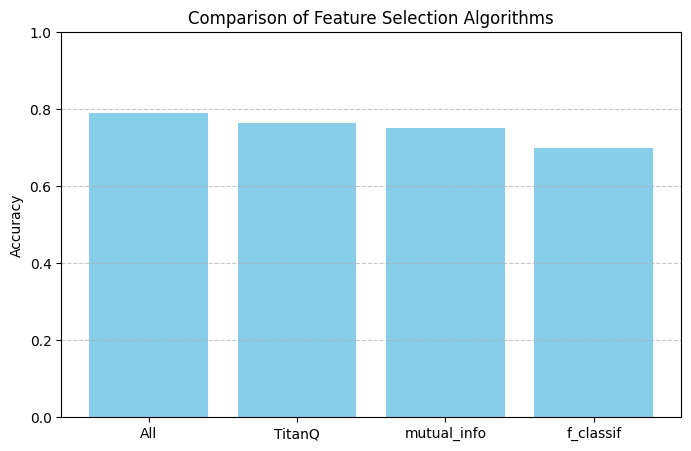

In [12]:
algorithms = ['All', 'TitanQ', 'mutual_info', 'f_classif']
accuracies = [all_acc, titanq_acc,mutual_info_acc, f_classif_acc]

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(algorithms, accuracies, color='skyblue')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Comparison of Feature Selection Algorithms')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()